In [1006]:
from urllib import request as ur
from bs4 import BeautifulSoup as bs
import re

from imdb import IMDb

from math import ceil
from numpy import inf, nan
import ast

import time

import pandas as pd
from json import loads
import matplotlib.pyplot as plt
import seaborn as sns

### Get movie database from YIFY site

In [16]:
first_page_url = 'https://yts.mx/api/v2/list_movies.json?limit=50&page=1'
request_with_ua = ur.Request(first_page_url, headers = {'User-Agent': 'some_user_agent'}) # have to set ua to not get error 403
data = loads(ur.urlopen(request_with_ua).read()) # parse result as JSON object

In [31]:
num_movies = data['data']['movie_count']
print('# of movies currently in YIFY database:', num_movies)

num_go_through = ceil(data['data']['movie_count'] / 50)
print('# of 50-result pages to scrape through:', num_go_through)

# of movies currently in YIFY database: 20458
# of 50-result pages to scrape through: 410


In [35]:
links = ['https://yts.mx/api/v2/list_movies.json?limit=50&page=' + str(i) for i in range(1, num_go_through + 1)]
links[:5]

['https://yts.mx/api/v2/list_movies.json?limit=50&page=1',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=2',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=3',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=4',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=5']

Parse first page, then go through all links

In [49]:
dt = pd.json_normalize(data['data']['movies'])
dt = dt[['title', 'year', 'runtime', 'rating', 'genres', 'summary', 'language', 'imdb_code']]
dt.head()

,title,year,runtime,rating,genres,summary,language,imdb_code
0,Go-Go Sisters,2018,118,7.4,"[Comedy, Drama]",Go-go sisters brings together two parallel sto...,vi,tt8081638
1,Chi Pheo Ngoai Truyen,2017,95,5.4,[Comedy],,vi,tt6947052
2,Husband Swap,2018,0,6.0,"[Drama, Romance]",,vi,tt9020602
3,Than Tuong,2013,113,7.2,"[Comedy, Drama, Romance]",Tri (Harry Lu) is the only son in a prestigiou...,vi,tt5231420
4,The Girl from Yesterday,2017,120,7.2,"[Comedy, Romance]",A teenage boy causes problems on an everyday b...,vi,tt7194618


Parse all data into one dataframe

In [50]:
def parse_urls(url):
    
    request_with_ua = ur.Request(url, headers = {'User-Agent': 'some_user_agent'}) # have to set ua to not get error 403
    data = loads(ur.urlopen(request_with_ua).read()) # parse result as JSON object
    
    dt = pd.json_normalize(data['data']['movies'])
    dt = dt[['title', 'year', 'runtime', 'rating', 'genres', 'summary', 'language', 'imdb_code']]
    
    return dt    

In [54]:
data = pd.concat([parse_urls(url) for url in links])

In [59]:
data.to_csv('movies.csv', index = False)

Put data in necessary format

In [63]:
data.dtypes # all good

title         object
year           int64
runtime        int64
rating       float64
genres        object
summary       object
language      object
imdb_code     object
dtype: object

### Enhance with data from IMDb (budget, BO opening weekend)

Will build scraper by checking results on the 'Dark Knight' web page

In [66]:
data[data['imdb_code'] == 'tt0468569']

,title,year,runtime,rating,genres,summary,language,imdb_code
30,The Dark Knight,2008,152,9.0,"[Action, Adventure, Crime, Drama, Thriller]",Set within a year after the events of Batman B...,en,tt0468569


In [77]:
imdb_code = 'tt0468569'
imdb_url = 'https://www.imdb.com/title/' + imdb_code + '/'

request = ur.Request(imdb_url,headers={'User-Agent': 'some_user_agent'})
html = ur.urlopen(request).read()
soup = bs(html, 'html.parser')
details = soup.find_all('div', {'class': ['article'], 'id' : ['titleDetails']})

Parsing through this HTML code would be the next step, but Python has an IMDb package which only needs one argument (movie id) and spits back everything

In [292]:
def get_imdb_data(imdb_code):
    
    imdb_code = re.sub('[^0-9]', '', imdb_code) # IMDb() needs the movie ID to be only the numeric part
    get_data = IMDb().get_movie(imdb_code)
    
    if ('cast' in get_data.data.keys()) is True:
        lead_actors = [people['name'] for people in get_data.data['cast'][:3]]
    else:
        lead_actors = float('nan')
    
    if ('directors' in get_data.data.keys()) is True:
        directors = [directors['name'] for directors in get_data.data['directors'][:2]]
    else:
        directors = float('nan')
        
    if ('writer' in get_data.data.keys()) is True:
        writers = [writers['name'] for writers in get_data.data['writer'][:2]]
    else:
        writers = float('nan')
    
    if ('box office' in get_data.data.keys()) is True:
        #budget, opening_we, ww_sum = re.sub('[^0-9.]','', get_data.data['box office']['Budget'].split()[0]), re.sub('[^0-9.]','', get_data.data['box office']['Opening Weekend United States'].split()[0]), re.sub('[^0-9.]','', get_data.data['box office']['Cumulative Worldwide Gross'].split()[0])
        financials = get_data.data['box office']
    else:
        #budget, opening_we, ww_sum = float('nan'), float('nan'), float('nan')
        financials = float('nan')

    return lead_actors, directors, writers, financials

Reduce data to run parsing function on (takes a lot of time to go through every movie)

In [310]:
data.head(), data.shape

(                     title  year  runtime  ...                                            summary language  imdb_code
 0            Go-Go Sisters  2018      118  ...  Go-go sisters brings together two parallel sto...       vi  tt8081638
 1    Chi Pheo Ngoai Truyen  2017       95  ...                                                          vi  tt6947052
 2             Husband Swap  2018        0  ...                                                          vi  tt9020602
 3               Than Tuong  2013      113  ...  Tri (Harry Lu) is the only son in a prestigiou...       vi  tt5231420
 4  The Girl from Yesterday  2017      120  ...  A teenage boy causes problems on an everyday b...       vi  tt7194618
 
 [5 rows x 8 columns],
 (20466, 8))

Minimum 70 minutes of runtime and minimum 2.5 / 10 ratings given

In [311]:
data = data[(data['runtime'] >= 70) & (data['rating'] >= 2.5)]
data.shape

(18721, 8)

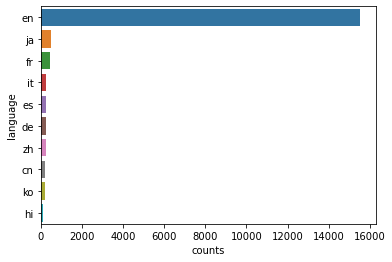

In [337]:
languages = data.groupby('language').size().reset_index(name = 'counts').sort_values('counts', ascending = False).head(10).reset_index(drop = True)
sns.barplot(y = 'language', x = 'counts', data = languages)
plt.show()

In [339]:
data = data[data['language'] == 'en']

In [ ]:
data.drop('language', 1, inplace = True)

In [727]:
data.shape

(15501, 7)

In [728]:
data.drop_duplicates(subset = 'imdb_code', keep = "last", inplace = True)

<ipython-input-728-98429cb03fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset = 'imdb_code', keep = "last", inplace = True)


In [729]:
data.shape

(15212, 7)

In [730]:
data.describe()

,year,runtime,rating
count,15212.000000,15212.000000,15212.000000
mean,2001.882264,100.644557,5.958756
std,20.177153,18.380970,1.220152
min,1915.000000,70.000000,2.500000
25%,1992.000000,89.000000,5.200000
50%,2011.000000,97.000000,6.100000
75%,2017.000000,108.000000,6.800000
max,2020.000000,364.000000,9.400000


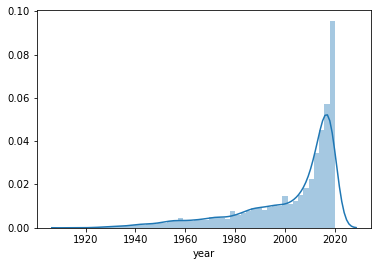

In [731]:
sns.distplot(data['year'])

In [735]:
data = data[data['year'] > 1980]

Apply function to get extra data from IMDb

In [736]:
data.reset_index(inplace = True, drop = True)

In [737]:
x = data.copy()

In [ ]:
start_time = time.time()

x['imdb_data'] = x['imdb_code'].apply(lambda x: get_imdb_data(x))

print("--- %s seconds ---" % (time.time() - start_time))

In [656]:
x.head()

,title,year,runtime,rating,genres,summary,language,imdb_code,imdb_data
0,Memoirs of an Invisible Man,1992,99,6.0,"[Comedy, Romance, Sci-Fi, Thriller]",Nick Halloway is made invisible during an acci...,en,tt0104850,"([Chevy Chase, Daryl Hannah, Sam Neill], [John..."
1,Barbie Princess Adventure,2020,72,7.0,[Animation],Sing-along with Barbie in the all-new musical ...,en,tt12767498,"([Ogie Banks, Eamon Brennan, Nakia Burrise], [..."
2,Feels Good Man,2020,92,7.2,"[Comedy, Documentary]","Artist Matt Furie, creator of the comic charac...",en,tt11394182,"([Robert Barnes, Samantha Bee, Hillary Clinton..."
3,Blue Money,1972,93,4.3,[Drama],Handsome and successful Jim appears to have it...,en,tt0211957,"([Alain Patrick, Barbara Mills, Inga Maria], [..."
4,Beautiful & Twisted,2015,86,5.6,"[Crime, Drama, Thriller]",Following the murder of hotel heir Ben Novack ...,en,tt3881768,"([Rob Lowe, Paz Vega, Candice Bergen], [Christ..."


In [657]:
x.to_csv('sample_movies_w_imdb_data.csv', index = False)

### Enhancement ideas so far
1. Scrape IMDB webpage
2. Use IMDb() function from imdb py package
3. Use TMDb API to parse an IMDB id, find TMDb id and via the TMDb id get budget and revenue data

#### Will use option # 3 as scraping is time consuming, IMDb() is very slow, TMDB API allows ~300k requests a day
 
 

In [703]:
pd.read_csv('sample_movies_w_imdb_data.csv')['imdb_data'][0]

"(['Chevy Chase', 'Daryl Hannah', 'Sam Neill'], ['John Carpenter'], ['H.F. Saint', 'Robert Collector'], {'Budget': '$40,000,000 (estimated)'})"

In [844]:
def enhance_via_tmdb_api(imdb_id):
    
    api = '7031a9194bc4599cfda684b748a523a9'

    link = 'https://api.themoviedb.org/3/find/' + imdb_id + '?api_key=' + api + '&language=en-US&external_source=imdb_id'
    read_json_imdb = loads(ur.urlopen(link).read())
    
    if read_json_imdb['movie_results'] != []:
        tmdb_id = read_json_imdb['movie_results'][0]['id'] # get tmdb id of the movie
    else:
        return [], [], [], []        

    link = 'https://api.themoviedb.org/3/movie/' + str(tmdb_id) + '?api_key=' + api + '&language=en-US'
    
    try:
        
        # get financials
        financials = loads(ur.urlopen(link).read())

        budget = financials['budget']
        revenue = financials['revenue']

        financials = {'budget' : budget, 'revenue' : revenue}

        # get cast / crew data
        link = 'https://api.themoviedb.org/3/movie/' + str(tmdb_id) + '/credits?api_key=' + api
        cast_crew = loads(ur.urlopen(link).read())

        # actors
        actors = []
        limit = 3
        for i, actor in enumerate(cast_crew['cast']):
            actors.append(actor['name'])
            if i == limit - 1:
                break

        # writers and directors
        if cast_crew['crew'] != []:
            crew = pd.json_normalize(cast_crew['crew'])
            crew = crew[(crew['department'].isin(['Writing', 'Directing'])) & (crew['job'].isin(['Screenplay', 'Director']))]
            writers = list(crew[crew['department'] == 'Writing']['name'][:2])
            directors = list(crew[crew['department'] == 'Directing']['name'][:2])
        else:
            writers, directors = [], []
        
    except ur.HTTPError as err:
        if err.code == 404:
            return [], [], [], []
    
    return actors, directors, writers, financials

In [1234]:
x = data.copy()[10000:]

In [1236]:
start_time = time.time()
x['imdb_data'] = x['imdb_code'].apply(lambda x: enhance_via_tmdb_api(x))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2418.4689898490906 seconds ---


In [1237]:
x.to_csv('movies_w_imdb_data_6.csv', index = False)

In [1238]:
x = pd.read_csv('movies_w_imdb_data_all.csv').append(x).reset_index(drop = True)
x.shape

(12904, 8)

In [1241]:
x.to_csv('movies_w_imdb_data_all.csv', index = False)

In [1243]:
x = pd.read_csv('movies_w_imdb_data_all.csv')
x.head()

,title,year,runtime,rating,genres,summary,imdb_code,imdb_data
0,Memoirs of an Invisible Man,1992,99,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",Nick Halloway is made invisible during an acci...,tt0104850,"(['Chevy Chase', 'Daryl Hannah', 'Sam Neill'],..."
1,Barbie Princess Adventure,2020,72,7.0,['Animation'],Sing-along with Barbie in the all-new musical ...,tt12767498,"(['America Young', 'Erica Lindbeck', 'Cassandr..."
2,Feels Good Man,2020,92,7.2,"['Comedy', 'Documentary']","Artist Matt Furie, creator of the comic charac...",tt11394182,"(['Matt Furie', 'Aiyana Udesen', 'Ursula Furie..."
3,Beautiful & Twisted,2015,86,5.6,"['Crime', 'Drama', 'Thriller']",Following the murder of hotel heir Ben Novack ...,tt3881768,"(['Rob Lowe', 'Paz Vega', 'Candice Bergen'], [..."
4,Battle Mountain: Graeme Obree's Story,2015,104,7.9,"['Biography', 'Documentary', 'Sport']","Addicted to breaking records, this former worl...",tt4905556,"([], ['Dave Street'], [], {'budget': 0, 'reven..."


### Clean data

In [1244]:
x['imdb_data'] = x['imdb_data'].apply(lambda x: ast.literal_eval(x))

In [1245]:
x['lead_actors'] = x['imdb_data'].apply(lambda x: x[0])
x['directors'] = x['imdb_data'].apply(lambda x: x[1])
x['writers'] = x['imdb_data'].apply(lambda x: x[2])
x['financials'] = x['imdb_data'].apply(lambda x: x[3])

x.drop('imdb_data', 1, inplace = True)

In [1246]:
x['director_main'] = x['directors'].apply(lambda x: x[0] if (x != []) else float('nan'))
x['director_sec'] = x['directors'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))

x.drop('directors', 1, inplace = True)

In [1247]:
x['actor_main'] = x['lead_actors'].apply(lambda x: x[0] if (x != []) else float('nan'))
x['actor_sec'] = x['lead_actors'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))
x['actor_thi'] = x['lead_actors'].apply(lambda x: x[2] if (x != [] and len(x) > 2) else float('nan'))

x.drop('lead_actors', 1, inplace = True)

In [1248]:
x['writer_main'] = x['writers'].apply(lambda x: x[0] if (x != [] ) else float('nan'))
x['writer_sec'] = x['writers'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))

x.drop('writers', 1, inplace = True)

In [1249]:
x['budget'] = x['financials'].apply(lambda x: x['budget'] if (isinstance(x, dict) and 'budget' in x.keys()) else float('nan'))
x['revenue'] = x['financials'].apply(lambda x: x['revenue'] if (isinstance(x, dict) and 'revenue' in x.keys()) else float('nan'))

x.drop('financials', 1, inplace = True)

In [1250]:
#x['budget'] = x['budget'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))
#x['open_we'] = x['open_we'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))
#x['ww_gross'] = x['ww_gross'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))

In [1251]:
x.to_csv('movies_w_imdb_data_processed.csv', index = False)

### Some viz around cast and staff

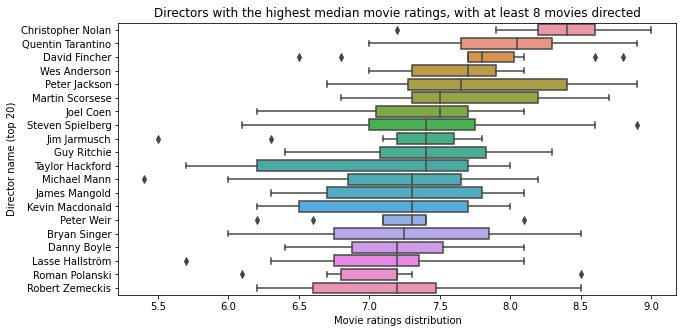

In [1264]:
top_dir_index = x.groupby(by=['director_main'])['rating'].agg(['count', 'median']).reset_index()
top_dir_index = top_dir_index[top_dir_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_index = top_dir_index[:20]

top_dir_data = x[x['director_main'].isin(top_dir_index['director_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'director_main', data = top_dir_data, order = top_dir_index['director_main'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Director name (top 20)")
plt.title("Directors with the highest median movie ratings, with at least 8 movies directed")
plt.show()

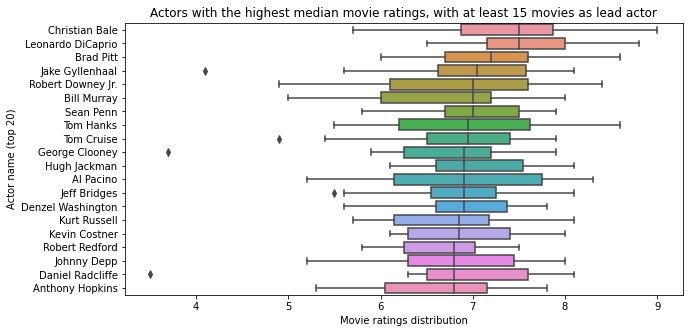

In [1259]:
top_act_index = x.groupby(by=['actor_main'])['rating'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 15].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = x[x['actor_main'].isin(top_act_index['actor_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'actor_main', data = top_act_data, order = top_act_index['actor_main'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie ratings, with at least 15 movies as lead actor")
plt.show()

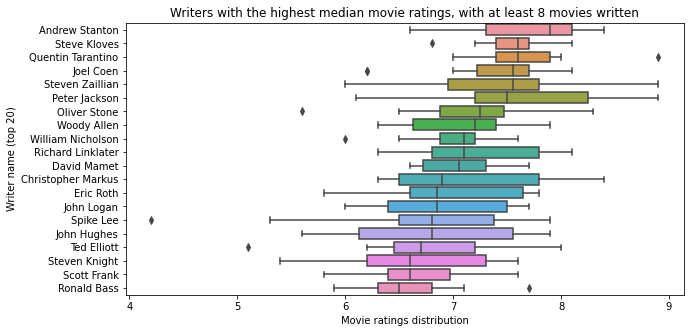

In [1263]:
top_wri_index = x.groupby(by=['writer_main'])['rating'].agg(['count', 'median']).reset_index()
top_wri_index = top_wri_index[top_wri_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_index = top_wri_index[:20]

top_wri_data = x[x['writer_main'].isin(top_wri_index['writer_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'writer_main', data = top_wri_data, order = top_wri_index['writer_main'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie ratings, with at least 8 movies written")
plt.show()

### Financials

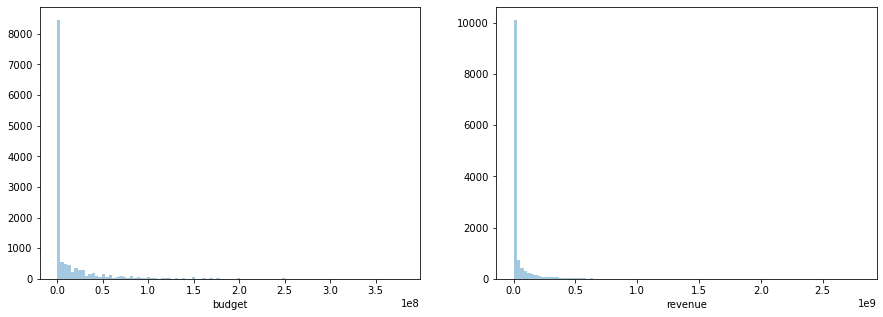

In [1265]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.distplot(x['budget'], bins = 100, kde = False, ax = ax[0])
sns.distplot(x['revenue'], bins = 100, kde = False, ax = ax[1])

plt.show()

In [1267]:
print('budget missing:', round(x['budget'].isnull().sum() / len(x['budget']) * 100, 3), '%')
print('revenue missing:', round(x['revenue'].isnull().sum() / len(x['revenue']) * 100, 3), '%')
print('budget = 0:', round((x['budget'] == 0).sum() / len(x['budget']) * 100, 3), '%')
print('revenue = 0:', round((x['revenue'] == 0).sum() / len(x['revenue']) * 100, 3), '%')

budget missing: 0.325 %
revenue missing: 0.325 %
budget = 0: 57.92 %
revenue = 0: 59.795 %


In [1268]:
x_finances = x[x['budget'] > 100000] # at least 100k budget

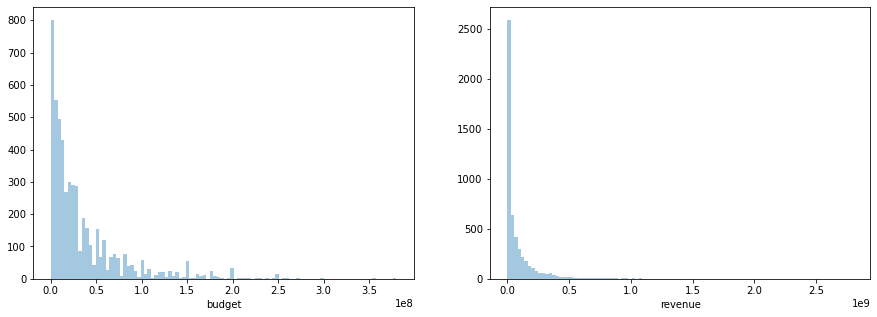

In [1269]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.distplot(x_finances['budget'], bins = 100, kde = False, ax = ax[0])
sns.distplot(x_finances['revenue'], bins = 100, kde = False, ax = ax[1])

plt.show()

Financials and rating relationship

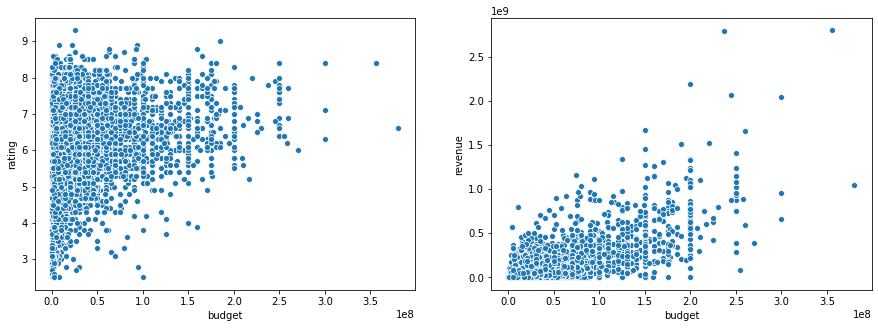

In [1270]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.scatterplot(x = 'budget', y = 'rating', data = x_finances, ax = ax[0])
sns.scatterplot(x = 'budget', y = 'revenue', data = x_finances, ax = ax[1])

plt.show()

Movies with largest budgets, largest opening weekends, largest cumulative gross worldwide boxes, ROIs

In [1271]:
x['roi'] = x['revenue'] / x['budget']
x['roi'] = x['roi'].replace(inf, nan)

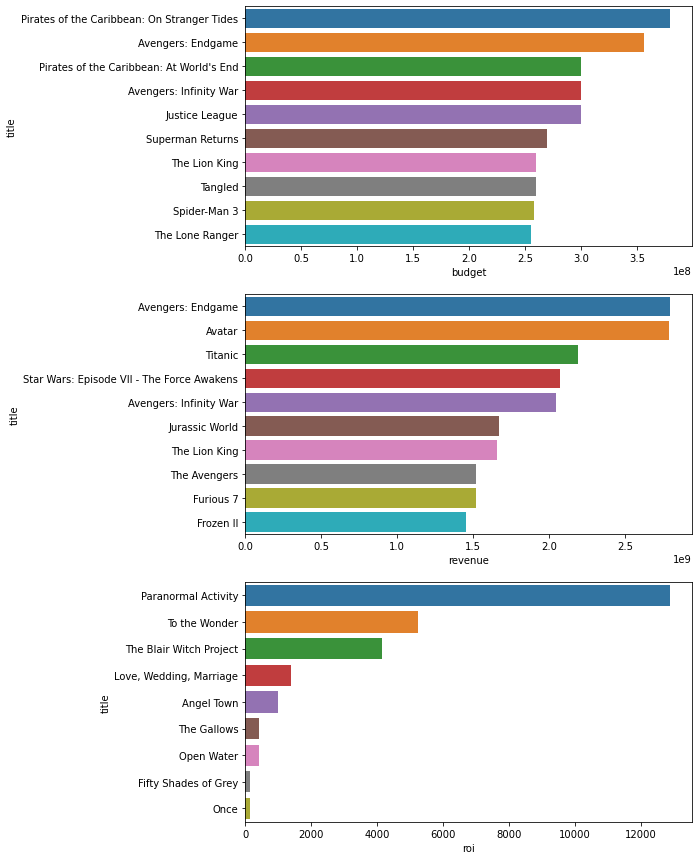

In [1275]:
top_budgets = x.sort_values('budget', ascending = False)[['title', 'budget']][:10].reset_index(drop = True)
top_revenue = x.sort_values('revenue', ascending = False)[['title', 'revenue']][:10].reset_index(drop = True)
top_roi = x.sort_values('roi', ascending = False)[['title', 'roi']][:10].reset_index(drop = True)
top_roi = top_roi[top_roi['roi'] < 1000000] # one error above 1mil ROI

fig, ax = plt.subplots(nrows = 3, figsize = (8, 15))

sns.barplot(x = 'budget', y = 'title', data = top_budgets, ax = ax[0])
sns.barplot(x = 'revenue', y = 'title', data = top_revenue, ax = ax[1])
sns.barplot(x = 'roi', y = 'title', data = top_roi, ax = ax[2])

plt.show()

Directors, writers working with largest budgets, ROIs

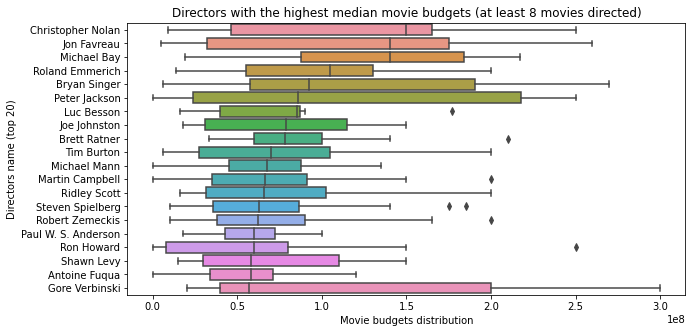

In [1279]:
top_dir_bud_index = x.groupby(by=['director_main'])['budget'].agg(['count', 'median']).reset_index()
top_dir_bud_index = top_dir_bud_index[top_dir_bud_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_bud_index = top_dir_bud_index[:20]
top_dir_bud_data = x[x['director_main'].isin(top_dir_bud_index['director_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'director_main', data = top_dir_bud_data, order = top_dir_bud_index['director_main'])
plt.xlabel("Movie budgets distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest median movie budgets (at least 8 movies directed)")
plt.show()

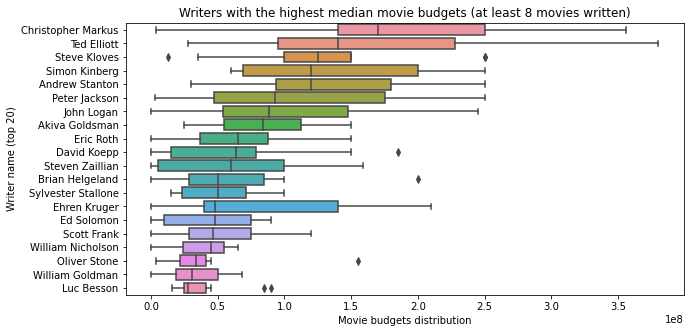

In [1283]:
top_wri_bud_index = x.groupby(by=['writer_main'])['budget'].agg(['count', 'median']).reset_index()
top_wri_bud_index = top_wri_bud_index[top_wri_bud_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_bud_index = top_wri_bud_index[:20]

top_wri_bud_data = x[x['writer_main'].isin(top_wri_bud_index['writer_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'writer_main', data = top_wri_bud_data, order = top_wri_bud_index['writer_main'])
plt.xlabel("Movie budgets distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie budgets (at least 8 movies written)")
plt.show()

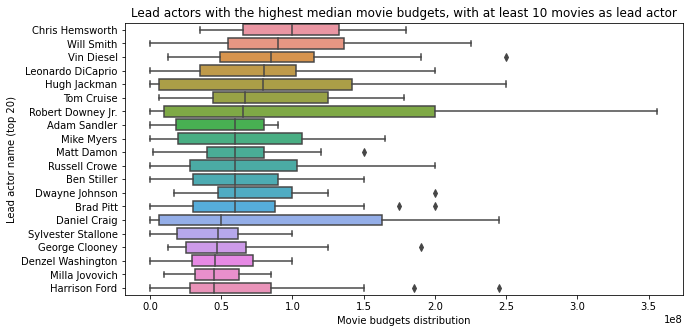

In [1287]:
top_act_bud_index = x.groupby(by=['actor_main'])['budget'].agg(['count', 'median']).reset_index()
top_act_bud_index = top_act_bud_index[top_act_bud_index['count'] > 10].sort_values('median', ascending = False).reset_index(drop = True)
top_act_bud_index = top_act_bud_index[:20]

top_act_bud_data = x[x['actor_main'].isin(top_act_bud_index['actor_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'actor_main', data = top_act_bud_data, order = top_act_bud_index['actor_main'])
plt.xlabel("Movie budgets distribution")
plt.ylabel("Lead actor name (top 20)")
plt.title("Lead actors with the highest median movie budgets, with at least 10 movies as lead actor")
plt.show()

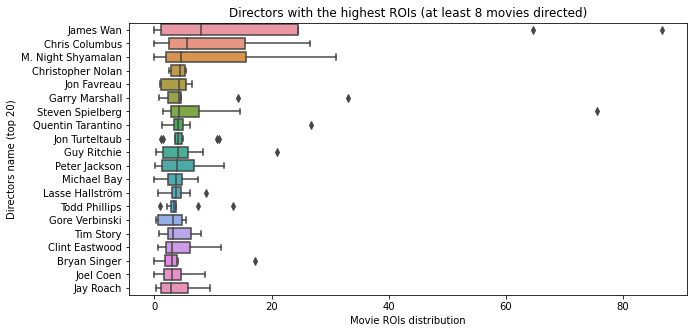

In [1292]:
top_dir_roi_index = x.groupby(by=['director_main'])['roi'].agg(['count', 'median']).reset_index()
top_dir_roi_index = top_dir_roi_index[top_dir_roi_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_roi_index = top_dir_roi_index[:20]

top_dir_roi_data = x[x['director_main'].isin(top_dir_roi_index['director_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'director_main', data = top_dir_roi_data, order = top_dir_roi_index['director_main'])
plt.xlabel("Movie ROIs distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest ROIs (at least 8 movies directed)")
plt.show()

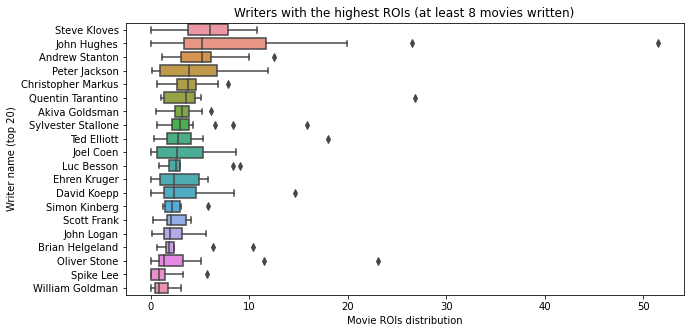

In [1297]:
top_wri_roi_index = x.groupby(by=['writer_main'])['roi'].agg(['count', 'median']).reset_index()
top_wri_roi_index = top_wri_roi_index[top_wri_roi_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_roi_index = top_wri_roi_index[:20]

top_wri_roi_data = x[x['writer_main'].isin(top_wri_roi_index['writer_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'writer_main', data = top_wri_roi_data, order = top_wri_roi_index['writer_main'])
plt.xlabel("Movie ROIs distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest ROIs (at least 8 movies written)")
plt.show()

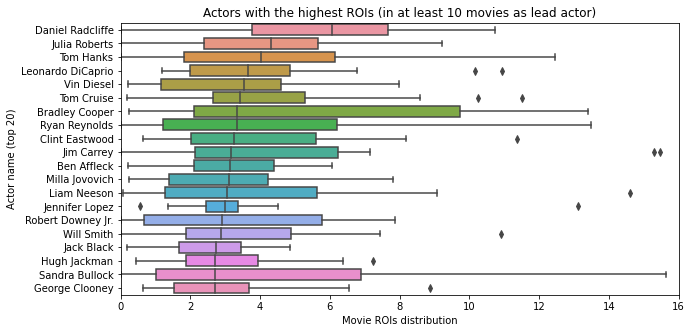

In [1308]:
top_act_roi_index = x.groupby(by=['actor_main'])['roi'].agg(['count', 'median']).reset_index()
top_act_roi_index = top_act_roi_index[top_act_roi_index['count'] > 10].sort_values('median', ascending = False).reset_index(drop = True)
top_act_roi_index = top_act_roi_index[:20]

top_act_roi_data = x[x['actor_main'].isin(top_act_roi_index['actor_main'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'actor_main', data = top_act_roi_data, order = top_act_roi_index['actor_main'])
plt.xlabel("Movie ROIs distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest ROIs (in at least 10 movies as lead actor)")
plt.xlim(0, 16)
plt.show()

### Apply pd.explode() and run visuals on all actors, dirs and writers (not just leading / primary ones)

In [1321]:
x = pd.read_csv('movies_w_imdb_data_all.csv')

x['imdb_data'] = x['imdb_data'].apply(lambda x: ast.literal_eval(x))
x['lead_actors'] = x['imdb_data'].apply(lambda x: x[0])
x['directors'] = x['imdb_data'].apply(lambda x: x[1])
x['writers'] = x['imdb_data'].apply(lambda x: x[2])
x['financials'] = x['imdb_data'].apply(lambda x: x[3])

x.drop('imdb_data', 1, inplace = True)

x['budget'] = x['financials'].apply(lambda x: x['budget'] if (isinstance(x, dict) and 'budget' in x.keys()) else float('nan'))
x['revenue'] = x['financials'].apply(lambda x: x['revenue'] if (isinstance(x, dict) and 'revenue' in x.keys()) else float('nan'))

x.drop('financials', 1, inplace = True)

x.head(1)

,title,year,runtime,rating,genres,summary,imdb_code,lead_actors,directors,writers,budget,revenue
0,Memoirs of an Invisible Man,1992,99,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",Nick Halloway is made invisible during an acci...,tt0104850,"[Chevy Chase, Daryl Hannah, Sam Neill]",[John Carpenter],"[William Goldman, Robert Collector]",40000000.0,14358033.0


#### Actors

In [1323]:
actors = x.explode('lead_actors')[['title', 'lead_actors', 'rating', 'budget', 'revenue']].reset_index(drop = True)
actors['roi'] = actors['revenue'] / actors['budget']
actors.head(3)

,title,lead_actors,rating,budget,revenue,roi
0,Memoirs of an Invisible Man,Chevy Chase,6.0,40000000.0,14358033.0,0.358951
1,Memoirs of an Invisible Man,Daryl Hannah,6.0,40000000.0,14358033.0,0.358951
2,Memoirs of an Invisible Man,Sam Neill,6.0,40000000.0,14358033.0,0.358951


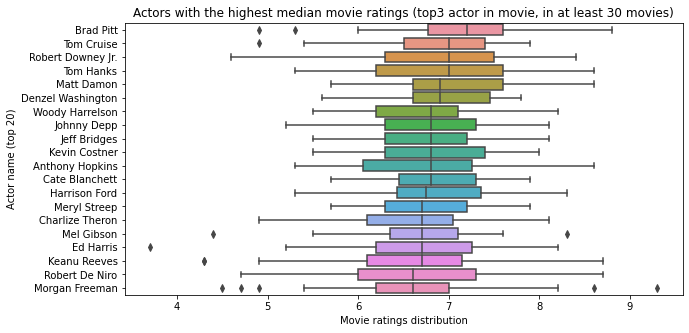

In [1329]:
top_act_index = actors.groupby(by=['lead_actors'])['rating'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 30].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie ratings (top3 actor in movie, in at least 30 movies)")
plt.show()

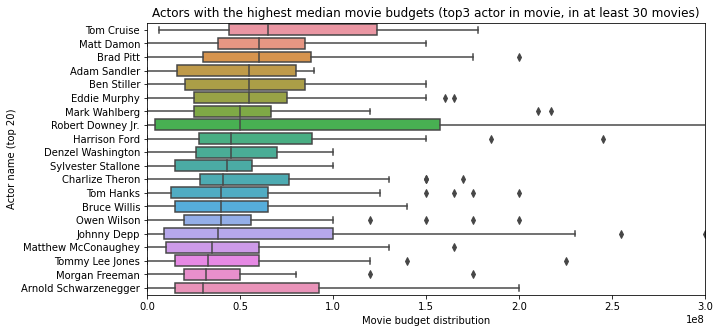

In [1339]:
top_act_index = actors.groupby(by=['lead_actors'])['budget'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 30].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie budget distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie budgets (top3 actor in movie, in at least 30 movies)")
plt.xlim(0, 3e8)
plt.show()

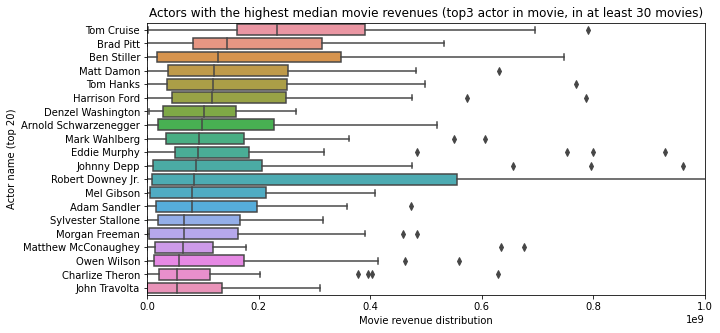

In [1341]:
top_act_index = actors.groupby(by=['lead_actors'])['revenue'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 30].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'revenue', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie revenue distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie revenues (top3 actor in movie, in at least 30 movies)")
plt.xlim(0, 1e9)
plt.show()

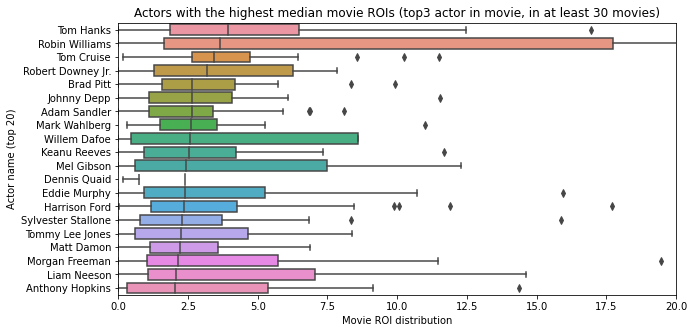

In [1344]:
top_act_index = actors.groupby(by=['lead_actors'])['roi'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 30].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie ROI distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie ROIs (top3 actor in movie, in at least 30 movies)")
plt.xlim(0, 20)
plt.show()

#### Directors

TODO: 
1. Directors, Writers (all, not just lead)
2. year - rating
3. year - budget
4. year- revenue
5. year - roi
6. genre - rating
7. genre - rating
8. genre - budget
9. genre- revenue
10. genre - roi
11. roi ~ dummies(couple of lead actors, directors, writers) (+ maybe budget or log(budget))